#Training a Fashion Image Classifier with PyTorch


# Environment Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Data Preparation and Hardware Configuration

In [2]:
# Define the image transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL images to Tensors and normalizes values to [0, 1]
])

# Download and initialize the MNIST Datasets
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

# Set the processing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.47MB/s]


# CNN Model Architecture

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Convolutional Layer: Detects edges and shapes
        self.conv = nn.Conv2d(1, 32, kernel_size=3)   # 1 input channel (gray) -> 32 feature maps

        # 2. Pooling Layer: Reduces image size to focus on important features
        self.pool = nn.MaxPool2d(2, 2)

        # 3. Fully Connected (Dense) Layers: Classification head
        self.fc1 = nn.Linear(32 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, 10)  # Output: 10 classes for digits 0-9

    def forward(self, x):
        x = F.relu(self.conv(x))       # Apply convolution and ReLU activation
        x = self.pool(x)               # Compress dimensions

        # Flattening: Reshape from (Batch, 32, 13, 13) to (Batch, 5408)
        x = x.view(x.size(0), 32 * 13 * 13)

        x = F.relu(self.fc1(x))        # Dense layer with activation
        x = self.fc2(x)                # Output layer (Logits)
        return x

# Instantiate the model and move it to the GPU/CPU
model = CNNModel().to(device)

# Loss Function and Optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# The Training and Validation Loop

In [5]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(10):
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(correct / total)
    # -------------------------------
    # Validation
    # -------------------------------
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_acc.append(correct_val / total_val)

    print(f"Epoch {epoch+1}/10 - "
          f"Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_acc[-1]:.4f} - "
          f"Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_acc[-1]:.4f}")

Epoch 1/10 - Train Loss: 0.2108 - Train Acc: 0.9365 - Val Loss: 0.0845 - Val Acc: 0.9736
Epoch 2/10 - Train Loss: 0.0682 - Train Acc: 0.9795 - Val Loss: 0.0610 - Val Acc: 0.9801
Epoch 3/10 - Train Loss: 0.0456 - Train Acc: 0.9861 - Val Loss: 0.0443 - Val Acc: 0.9862
Epoch 4/10 - Train Loss: 0.0329 - Train Acc: 0.9901 - Val Loss: 0.0447 - Val Acc: 0.9851
Epoch 5/10 - Train Loss: 0.0245 - Train Acc: 0.9925 - Val Loss: 0.0485 - Val Acc: 0.9849
Epoch 6/10 - Train Loss: 0.0185 - Train Acc: 0.9941 - Val Loss: 0.0491 - Val Acc: 0.9857
Epoch 7/10 - Train Loss: 0.0130 - Train Acc: 0.9959 - Val Loss: 0.0485 - Val Acc: 0.9859
Epoch 8/10 - Train Loss: 0.0109 - Train Acc: 0.9967 - Val Loss: 0.0512 - Val Acc: 0.9840
Epoch 9/10 - Train Loss: 0.0086 - Train Acc: 0.9971 - Val Loss: 0.0458 - Val Acc: 0.9862
Epoch 10/10 - Train Loss: 0.0054 - Train Acc: 0.9984 - Val Loss: 0.0515 - Val Acc: 0.9859


# Visualizing Model Performance


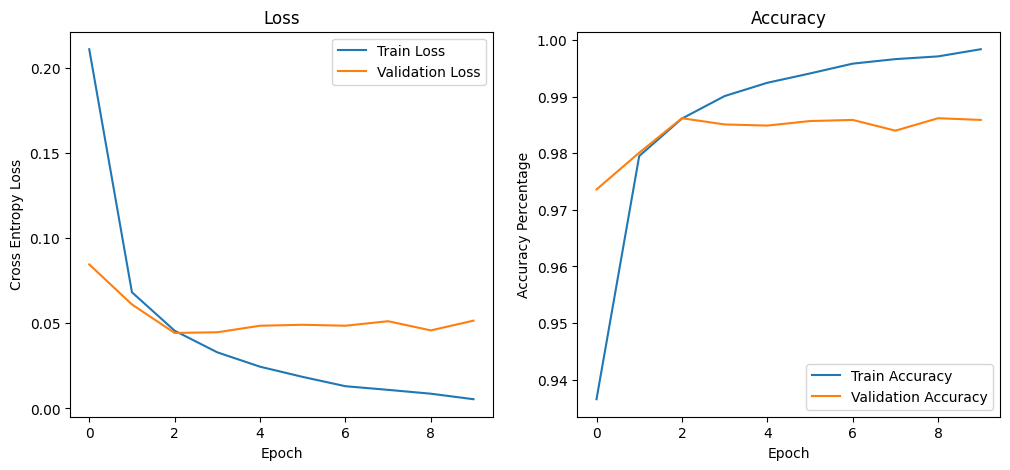

In [6]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Percentage")
plt.legend()

plt.show()

# 🛠 Technical Analysis: Training Dynamics & Generalization

The following plots visualize the performance of the **DynamicCNN** architecture on the **MNIST** dataset over 10 epochs.

---

## 📉 Loss Analysis: The Generalization Limit

- **Rapid Convergence:**  
  The training loss (blue) exhibits a steep decay, dropping from ~0.21 to under 0.05 within the first three epochs.  
  This confirms that the **Adam optimizer** and the chosen learning rate (`1e-3`) are well-calibrated for the model's loss surface.

- **Divergence Point:**  
  At Epoch 2, a distinct "inflection point" appears. While the training loss continues toward zero, the validation loss (orange) plateaus and begins a slight upward trend.

- **Research Insight:**  
  This divergence represents the **Generalization Gap**. The model is beginning to minimize the empirical risk (training loss) by memorizing noise or dataset-specific artifacts, rather than learning truly invariant features.

---

## 📈 Accuracy Analysis: Overconfidence and Saturation

- **Performance Metrics:**  
  The model achieves a near-perfect training accuracy of **99.8%**, while validation accuracy saturates at **98.6%**.

- **The Overconfidence Problem:**  
  In a Probabilistic ML context, the growing gap between these curves suggests a lack of **Model Calibration**.  
  Even as validation accuracy remains high, the rising validation loss indicates the model is becoming increasingly "overconfident" in its incorrect predictions.

- **Saturation:**  
  The plateau at ~98.6% suggests we have reached the maximum representational capacity of this CNN topology without further regularization.

---

## 🔬 Proposed Research Iterations (Next Steps)

To bridge the generalization gap and move toward a more **Uncertainty-Aware** system, the following iterations are proposed:

- **Stochastic Regularization:**  
  Implement **Dropout (p=0.25)** to break co-adaptation between neurons and improve feature robustness.

- **Model Calibration:**  
  Utilize **Temperature Scaling** or **Label Smoothing** to align the model's softmax confidence with its actual predictive accuracy.

- **Data Invariance:**  
  Introduce **Transformation Invariance** via data augmentation (rotations, scaling) to ensure the model learns the "shape" of the digits rather than absolute pixel positions.

- **Ensemble Variance:**  
  Train an ensemble of these models to use predictive variance between different initializations as a proxy for **epistemic uncertainty**.

---

### Why this version is better for your application

- **Model Calibration:** Demonstrates that the model "knows how sure it is," a key concept in th
